In [2]:
import pandas as pd
import geopandas as gp
import numpy as np 
import xlrd
import os
import fiona
from statistics import mean, median
import string
import math
import re
import warnings

# A submodule of Maup (GerryChain) creates a conflict with pygeos. This notebook requires that 
# pygeos *not* be loaded in order to function.
# import pygeos
gp.options.use_pygeos = False
import maup

from shapely.geometry import Polygon
from shapely.ops import cascaded_union
from shapely.errors import TopologicalError

pd.set_option('display.max_rows', 200)

/usr/local/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.0-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


# VEST PA 2020

## VEST Documentation

### Sources

Election results primarily from individual county precinct reports as processed via OpenElections (https://github.com/openelections/openelections-data-pa/). Precinct data was corrected with canvass reports for the following counties: Cambria, Crawford, Forest, Juniata, York. The Susquehanna County precinct results were provided by the Pennsylvania Secretary of State Bureau of Elections.

Due to court orders involving ballots that were segregated until legal challenges were resolved the certified results from nearly all counties differ from the official results certified by the state. State courts ordered segregated ballots to be included for state offices whereas federal courts ordered that they be excluded for federal offices. As the orders were issued after the county certification deadline these votes were added to the state offices for 57 counties that did not include them in precinct reports and removed from federal offices in 10 counties that did include them in precinct reports. The precinct results in the VEST shapefiles are those that were certified by the respective counties.

Federal ballots in Philadelphia were reported at the citywide level. These are distributed by candidate to precincts based on their share of the precinct-level reported vote.

### Shapefiles

Precinct shapefiles primarily from the U.S. Census Bureau's 2020 Redistricting Data Program Phase 2 release. The shapefiles from Delaware County and the City of Pittsburgh are from the respective jurisdictions. Precinct numbers were corrected to match the 2020 voter file in the following locales: Allegheny (Elizabeth, Pittsburgh W12), Blair (Greenfield), Bradford (Athens), Greene (Dunkard, Monongahela), Monroe (Smithfield), Montgomery (Hatfield), Northampton (Bethlehem Twp), Perry (Toboyne), Union (Union), Washington (New Eagle, Somerset), York (Fairview). VTD codes in Philadelphia were edited to match the city ward/division numbers.

The U.S. Census Bureau's final VTD release was used for all of Crawford, Jefferson, McKean, Northumberland. A number of precincts statewide were also replaced with the final VTDs due to updated municipal boundaries. 

The final VTD release was also used for precincts that were altered before the 2020 general election in the following locales: Adams (Reading), Allegheny (Marshall), Armstrong (Ford City), Cambria (N Cambria), Centre (State College), Chester (Valley N), Clearfield (Bradford), Franklin (Montgomery, Peters), Greene (Dunkard), Lebanon (Cornwall, Jackson, N Cornwall, S Londonderry, Swatara), Luzerne (Butler, Dallas, Fairview, Kingston Boro, Kingston Twp, Rice, Salem, Sugarloaf, Wright), Lycoming (Williamsport), Mercer (S Pymatuning), Monroe (Jackson), Montgomery (New Hanover, Upper Merion), Northampton (Allen), Philadelphia (Wards 2, 5, 8, 18, 21, 40, 63), Venango (Cranberry), Washington (Amwell, Cecil, Donegal, N Strabane, S Strabane); Westmoreland: (Murrysville), York (W Manheim).

Precinct boundaries throughout the state were edited to match voter assignments in the PA Secretary of State voter file from the 2020 election cycle. While some edits reflect official updates to wards or divisions the majority involve voters incorrectly assigned to voting districts by the counties. As such the VEST shapefile endeavors to reflect the de facto precinct boundaries and these often differ from the official voting district boundaries in some cases quite drastically. Wherever possible edits were made using census boundaries or alternatively using the parcel shapefiles from the respective counties. 

In certain areas voter assignments appear so erratic that it is impractical to place all voters within their assigned precinct. These areas were edited so as to place as many voters as possible within their assigned precinct without displacing a greater number from their assigned precinct. In general, municipal boundaries were retained except where a significant number of voters were misassigned to the wrong municipality. In cases where the odd/even split was incorrectly reversed for precinct boundary streets the official boundary was retained. All such cases involved near equal number of voters swapped between voting districts.

The following revisions were made to the base shapefiles to match the de facto 2020 precinct boundaries consistent with the voter file. Individual precincts are noted in cases of splits or merges. Due to the sheer number of edits boundary adjustments are listed at the borough/township level. There may be as many as two dozen individual precincts that were revised within a given municipality.

In some cases the edited precinct boundaries noted below match those of the final Census VTD release.

- Adams: Adjust Cumberland, Franklin<br>
- Allegheny: Split Pittsburgh W5 11/17; Merge Pittsburgh W16 9/11/12; Align McCandless with municipal boundary; Adjust Baldwin, Bethel Park, Braddock, Brentwood, Castle Shannon, Clairton, Collier, Coraopolis, Crescent, Dormont, Dravosburg, Duquesne, E Deer, E McKeesport, E Pittsburgh, Elizabeth, Emsworth, Forward, Glassport, Hampton, Harmar, Ingram, Jefferson Hills, Kennedy, Leet, Liberty, Marshall, McCandless, McKees Rocks, McKeesport, Monroeville, Moon, Mount Lebanon, Munhall, N Fayette, N Versailles, O'Hara, Oakdale, Penn Hills, Pine, Pittsburgh (nearly all wards), Pleasant Hills, Reserve, Richland, Ross, Scott, Sewickley, Shaler, S Fayette, S Park, Stowe, Swissvale, Upper St. Clair, W Deer, W Homestead, W Mifflin, W View, Whitaker, Whitehall, Wilkins, Wilkinsburg<br>
- Armstrong: Align Dayton, Elderton, Ford City, Kittanning, N Apollo with municipal boundaries; Adjust Cowanshannock, Ford City, Gilpin, Kiskiminetas, Kittanning, Manor, N Buffalo, Parks, Parker City, S Buffalo<br>
- Beaver: Adjust Aliquippa, Ambridge, Baden, Beaver, Brighton, Center, Chippewa, Conway, Economy, Franklin, Hanover, Harmony, Hopewell, Midland, Monaca, N Sewickley<br>
- Bedford: Adjust Bedford Boro, Bedford Twp<br>
- Berks: Adjust Cumru, Douglass, Earl, Oley, Maxatawny, Robeson, Sinking Spring, Union<br>
- Blair: Merge Tunnelhill/Allegheny Twp 4; Align Altoona, Bellwood, Duncansville, Hollidaysburg, Newry, Roaring Spring, Tyrone, Williamsburg with municipal boundaries; Adjust Allegheny, Altoona, Antis, Frankstown, Freedom, Greenfield, Huston, Juniata, N Woodbury, Logan, Snyder, Tyrone Boro, Tyrone Twp<br>
- Bucks: Align Sellersville, Tullytown with municipal boundaries; Adjust Bensalem, Bristol Boro, Bristol Twp, Buckingham, Doylestown Twp, Falls, Hilltown, Lower Makefield N, Lower Southampton E, Middletown, Milford, Morrissville, Newtown Twp, Northampton, Solebury Lower, Solebury, Springfield, Tinicum, Upper Makefield, Upper Southampton E, Warminster, Warrington, W Rockhill<br>
- Butler: Align Butler Twp, Valencia with municipal boundaries; Adjust Adams, Buffalo, Butler Boro, Butler Twp, Center, Cranberry E, Cranberry W, Jackson, Jefferson, Zelienople<br>
- Cambria: Align Daisytown, Sankertown, W Taylor, Wilmore with municipal boundaries; Adjust Cambria, Conemaugh, Croyle, E Taylor, Ebensburg, E Carroll, Geistown, Jackson, Johnstown W8, W17, W20, Lower Yoder, Northern Cambria, Portage Boro, Portage Twp, Richland, Southmont, Stonycreek, Summerhill, Susquehanna, Upper Yoder, W Carroll, Westmont<br>
- Cameron: Adjust Emporium, Shippen<br>
- Carbon: Adjust Jim Thorpe, Kidder, Mahoning, New Mahoning, Summit Hill<br>
- Centre: Merge Ferguson Northeast 1 A/B; Adjust Benner,  Ferguson, Patton<br>
- Chester: Adjust Birmingham, E Bradford S, E Fallowfield, E Goshen, E Marlborough, Easttown, N Coventry, Spring City, Tredyffrin M, Uwchlan, Valley N, W Bradford, W Caln, W Goshen N, W Goshen S, Westtown<br>
- Clarion: Align Shippenville with municipal boundary; Merge Emlenton/Richland; Adjust Clarion, Highland, Farmington, Knox<br>
- Clearfield: Adjust Decatur, Woodward<br>
- Columbia: Merge Ashland/Conyngham; Adjust Orange, Scott West<br>
- Crawford: Align Cochranton, Richmond with municipal boundaries<br>
- Cumberland: Split Lower Allen 1/Annex; Align Carlisle, E Pennsboro, Hampton, Lemoyne, Lower Allen, Mechanisburg, Middlesex, Mount Holly Springs, N Middleton, Shiremanstown, Silver Spring, W Pennsboro, Wormsleysburg with municipal boundaries<br>
- Dauphin: Align Middletown with municipal boundary; Adjust Derry, Harrisburg W1, W7, W8, W9, Hummelstown, Lower Paxton, Lykens, Middletown<br>
- Delaware: Adjust Chester, Concord, Darby Boro, Darby Twp, Haverford, Marple, Nether Providence, Newtown, Radnor, Ridley, Sharon Hill, Thornbury, Tinicum, Trainer, Upper Chichester, Upper Darby, Upper Providence<br>
- Elk: Adjust Johnsonburg, Ridgeway Boro, Ridgeway Twp, St. Marys<br>
- Erie: Adjust Erie W1, W4, W5, W6, Greene, Lawrence Park, McKean, Millcreek, North East<br>
- Fayette: Align Dunbar, Uniontown with municipal boundaries; Adjust Brownsville, Bullskin, Dunbar, Georges, German, Luzerne, N Union, Redstone<br>
- Franklin: Align Mercersburg with municipal boundary; Adjust Antrim, Fannett, Greene, Guilford, Hamilton, Metal, Peters, Quincy, St. Thomas, Southampton, Washington<br>
- Fulton: Align McConnellsburg with municipal boundary<br>
- Greene: Align Carmichaels with municipal boundary; Adjust Cumberland, Franklin, Jefferson, Lipencott, Mather, Morgan Chart, Monongahela, Nemacolin<br>
- Huntingdon: Adjust Huntingdon, Mount Union<br>
- Jefferson: Adjust Punxsutawney<br>
- Lackawanna: Adjust Archbald, Blakely, Carbondale, Clarks Summit, Dickson City, Dunmore, Fell, Jermyn, Jessup, Mayfield, Moosic, Old Forge, Olyphant, Scranton W1, W2, W3, W6, W7, W10, W12, W13, W14, W15, W16, W19, W20, W23, S Abington, Taylor, Throop<br>
- Lancaster: Split Lancaster 7-8 CV/LS; Adjust Brecknock, Columbia, E Hempfield, E Lampeter, E Petersburg, Elizabethtown, Ephrata, Lancaster W4, W8, Lititz, Manheim, Manor, Millersville, Mt Joy Twp, New Holland, Penn, Providence, Rapho, Warwick, W Cocalico, W Donegal, W Hempfield<br>
- Lawrence: Adjust Neshannock<br>
- Lebanon: Adjust Cornwall, S Lebanon<br>
- Lehigh: Split Allentown Ward 17-4/Parkland; Adjust Lower Macungie, Salisbury<br>
- Luzerne: Align Avoca, Pittston with municipal boundaries; Adjust Butler, Exeter, Fairview, Foster, Hanover, Hazle, Jenkins, Larksville, Lehman, Nanticoke, Plains, Smoyersville, W Wyoming, Wilkes-Barre<br>
- Lycoming: Adjust Jersey Shore<br>
- McKean: Align Foster with municipal boundary; Adjust Bradford, Bradford Twp, Foster, Hamlin, Keating<br>
- Mercer: Adjust Delaware, Fredonia, Greenville, Hempfield, Hermitage, Sharon, Sharpsville, W Salem<br>
- Mifflin: Split Brown Reedsville/Church Hill<br>
- Monroe: Align E Stroudsburg with municipal boundary; Adjust E Stroudsburg, Smithfield, Stroud, Tobyhanna<br>
- Montgomery: Adjust Abington, Lower Merion, Pottstown, Springfield, Upper Moreland, Upper Merion, Upper Providence<br>
- Northampton: Align Glendon, Walnutport with municipal boundaries; Adjust Bangor, Bethlehem W2, W3, W4, W7, W9, W14, W15, Bethlehem Twp, Bushkill, Easton, Forks, Hanover, Hellertown, Lehigh, Lower Mt Bethel, Lower Saucon, Moore, Nazareth, Palmer, Plainfield, Upper Mt Bethel, Washington, Williams<br>
- Northumberland: Adjust Coal, Kulpmont, Marion Heights, Milton, Mount Carmel, Northumberland, Point, Ralpho, Shamokin, Sunbury, Upper Augusta<br>
- Philadelphia: Adjust 1-19/21, 5-3/19, 7-2/3/17, 7-6/7, 9-5/6, 15-7/10, 17-20/26, 20-5/10, 21-1/15, 21-40/41, 22-21/26, 23-11/12, 25-9/17, 25-4/7/12, 25-10/12, 26-1/2, 27-7/8, 27-18/20/21, 28-1/8, 29-9/11, 29-10/17, 30-14/15, 31-5/6, 38-11/17, 38-13/20, 38-15/19, 40-12/18/19, 40-17/19, 42-3/4/7, 44-8/14, 50-3/12, 50-11/27, 52-2/6/9, 52-3/8, 57-6/7, 57-10/27, 57-17/28, 58-6/12, 62-5/19, 65-4/7, 65-11/16, 66-22/34<br>
- Pike: Adjust Matamoras<br>
- Potter: Adjust Galeton<br>
- Schuylkill: Adjust Coaldale, N Manheim, Norwegian, Porter, Pottsville<br>
- Somerset: Align New Centerville with municipal boundary; Adjust Conemaugh, Jefferson, Middlecreek, Paint, Somerset Boro<br>
- Susquehanna: Adjust Montrose; Lanesboro, Susquehanna Depot<br>
- Tioga: Adjust Delmar, Wellsboro<br>
- Union: Adjust Buffalo, White Deer<br>
- Venango: Adjust Cornplanter, Cranberry, Franklin, Oil City, Sugarcreek<br>
- Warren: Adjust Conewango<br>
- Washington: Align Allenport, Beallsville, Burgettstown, Canonsburg, Carroll, Charleroi, Claysville, Elco, Finleyville, Houston, Long Branch, McDonald, Midway, Monongahela, Speers, Twilight with municipal boundaries; Adjust Amwell, Bentleyville, California, Canonsburg, Canton, Cecil, Centerville, Chartiers, Donora, Fallowfield, Hanover, Independence, Mount Pleasant, N Franklin, N Strabane, Peters, Robinson, Smith, Somerset, S Franklin, Union Washington, W Brownsville<br>
- Wayne: Adjust Honesdale<br>
- Westmoreland: Align Greensburg with municipal boundary; Adjust Allegheny, Arnold, Bell, Derry, E Huntingdon, Fairfield, Greensburg W1-W8, Hempfield, Jeannette, Latrobe, Ligonier, Lower Burrell, Monessen, Mount Pleasant, New Kensington, N Belle Vernon, N Huntingdon, Penn, Rostraver, St. Clair, Scottdale, Sewickley, S Greensburg, S Huntingdon, Trafford, Upper Burrell, Unity, Vandergrift, Washington, Youngwood<br>
- York: Align E Prospect, Goldsboro, Jefferson, Manchester, Monaghan, Wellsville, York with municipal boundaries; Adjust Chanceford, Codorus, Conewago, Dover, Fairview, Hanover, Jackson, Lower Windsor, New Freedom, Newberry, N Codorus, Penn, Red Lion, Shrewsbury, Spring Garden, Springbettsbury, W Manchester, Windsor Boro, Windsor Twp, Wrightsville, York Twp, York W5, W6, W15<br>


### Races

G20PREDBID - Joseph R. Biden (Democratic Party)<br>
G20PRERTRU - Donald J. Trump (Republican Party)<br>
G20PRELJOR - Jo Jorgensen (Libertarian Party)<br>
<br>
G20ATGDSHA - Joshua D. Shapiro (Democratic Party)<br>
G20ATGRHEI - Heather S. Heidelbaugh (Republican Party)<br>
G20ATGLWAS - Daniel Wassmer (Libertarian Party)<br>
G20ATGGWEI - Richard L. Weiss (Green Party)<br>
<br>
G20AUDDAHM - Nilofer Nina Ahmad (Democratic Party)<br>
G20AUDRDEF - Timothy L. DeFoor (Republican Party)<br>
G20AUDLMOO - Jennifer Lynn Moore (Libertarian Party)<br>
G20AUDGFAI - Olivia Faison (Green Party)<br>
<br>
G20TREDTOR - Joseph M. Torsella (Democratic Party)<br>
G20TRERGAR - Stacy L. Garrity (Republican Party)<br>
G20TRELSOL - Joseph P. Soloski (Libertarian Party)<br>
G20TREGRUN - Timothy Runkle (Green Party)


## Load in VEST file

In [3]:
vest_pa_2020 = gp.read_file('./raw-from-source/VEST/pa_2020/pa_2020.shp')

<AxesSubplot:>

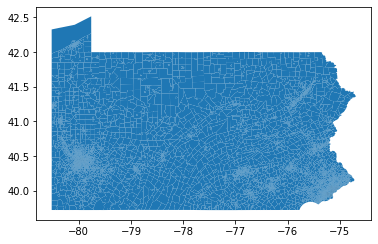

In [4]:
vest_pa_2020.plot()

## Load in OpenElections Results

In [5]:
oe_county_df = pd.read_csv('./raw-from-source/Election_Results/20201103__pa__general__county.csv')
oe_precinct_df = pd.read_csv('./raw-from-source/Election_Results/20201103__pa__general__precinct.csv')

/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (3,6,8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [6]:
candidate_to_vest_map = {
    'JOSEPH R. BIDEN': 'G20PREDBID', 
    'DONALD J. TRUMP': 'G20PRERTRU', 
    'JO JORGENSEN': 'G20PRELJOR', 
    'JOSH SHAPIRO': 'G20ATGDSHA', 
    'HEATHER HEIDELBAUGH': 'G20ATGRHEI', 
    'DANIEL WASSMER': 'G20ATGLWAS', 
    'RICHARD WEISS': 'G20ATGGWEI', 
    'NINA AHMAD': 'G20AUDDAHM', 
    'TIMOTHY DEFOOR': 'G20AUDRDEF', 
    'JENNIFER MOORE': 'G20AUDLMOO', 
    'OLIVIA FAISON': 'G20AUDGFAI', 
    'JOE TORSELLA': 'G20TREDTOR', 
    'STACY GARRITY': 'G20TRERGAR', 
    'JOE SOLOSKI': 'G20TRELSOL', 
    'TIMOTHY RUNKLE': 'G20TREGRUN'
}

Standardize/clean county dataframe

NOTE: OE County dataframe is missing quite a few counties...

In [7]:
oe_county_df
oe_county_df['candidate'] = oe_county_df['candidate'].fillna('')
oe_county_df['candidate'] = oe_county_df['candidate'].apply(lambda e: e.upper())
vote_cols = ['votes', 'election_day', 'mail', 'absentee', 'provisional']

for vc in vote_cols:
    oe_county_df[vc] = oe_county_df[vc].replace({',': ''}, regex=True)
    oe_county_df[vc] = oe_county_df[vc].fillna(0)
    oe_county_df[vc] = oe_county_df[vc].astype(int)


In [8]:
oe_county_df.to_csv('./oe-county-cleaned.csv', index=False)

### Process/Clean OE Precinct File

Perform rudimentary standardization/cleaning of the precinct data

In [9]:
oe_precinct_df['votes'] = oe_precinct_df['votes'].replace({',': ''}, regex=True)
oe_precinct_df['absentee'] = oe_precinct_df['absentee'].replace({',': ''}, regex=True)
oe_precinct_df['election_day'] = oe_precinct_df['election_day'].replace({',': ''}, regex=True)

In [10]:
oe_precinct_df['candidate'] = oe_precinct_df['candidate'].fillna('')

# remove commas/other separators from numeric columns
oe_precinct_df['votes'] = oe_precinct_df['votes'].replace({',': ''})
oe_precinct_df['absentee'] = oe_precinct_df['absentee'].replace({',': ''})
oe_precinct_df['election_day'] = oe_precinct_df['election_day'].replace({',': ''})

# numeric dtype conversions
oe_precinct_df['votes'] = oe_precinct_df['votes'].fillna(0)
oe_precinct_df['votes'] = oe_precinct_df['votes'].astype(int)
#oe_precinct_df['votes'] = oe_precinct_df['votes'].apply(pd.to_numeric)

oe_precinct_df['absentee'] = oe_precinct_df['absentee'].fillna(0)
oe_precinct_df['absentee'] = oe_precinct_df['absentee'].astype(int)
# oe_precinct_df['absentee'] = oe_precinct_df['absentee'].apply(pd.to_numeric)

oe_precinct_df['election_day'] = oe_precinct_df['election_day'].fillna(0)
oe_precinct_df['election_day'] = oe_precinct_df['election_day'].astype(int)
# oe_precinct_df['election_day'] = oe_precinct_df['election_day'].apply(pd.to_numeric)

# capitalize all candidate names
oe_precinct_df['candidate'] = oe_precinct_df['candidate'].apply(lambda e: e.upper())

In [11]:
oe_precinct_df.dtypes

county          object
precinct        object
office          object
district        object
candidate       object
party           object
votes            int64
absentee         int64
election_day     int64
dtype: object

In [12]:
oe_precinct_df['candidate'] = oe_precinct_df['candidate'].apply(lambda e: e.upper())

In [13]:
oe_precinct_df['office'].unique()

array(['President', 'Attorney General', 'Auditor General',
       'State Treasurer', 'U.S. House', 'State Senate', 'State House',
       'Ballots Cast', 'Registered Voters'], dtype=object)

In [14]:
# Collect presidential data
pres_dem = oe_precinct_df.loc[oe_precinct_df['candidate'] == 'JOSEPH R. BIDEN'].copy(deep=True)
pres_dem['candidate'] = 'JOSEPH R. BIDEN'
pres_rep = oe_precinct_df.loc[oe_precinct_df['candidate'] == 'DONALD J. TRUMP'].copy(deep=True)
pres_rep['candidate'] = 'DONALD J. TRUMP'
pres_lib = oe_precinct_df.loc[oe_precinct_df['candidate'].isin(['JO JORGENSEN', 'JORGENSEN AND COHEN', 'JORGENSEN/COHE'])].copy(deep=True)
pres_lib['candidate'] = 'JO JORGENSEN'

In [15]:
oe_precinct_df.loc[oe_precinct_df['office'] == 'Auditor General']['candidate'].unique()

array(['NINA AHMAD', 'TIMOTHY DEFOOR', 'JENNIFER MOORE', 'OLIVIA FAISON',
       'WRITE-INS', 'UNRESOLVED WRITE-IN', 'NINA AHMED',
       'OLIVIA FASON GREEN', 'WRITE-IN: SCATTERED', 'NOT ASSIGNED',
       'OVER VOTES', 'UNDER VOTES', 'OVERVOTE', 'WRITE-IN',
       'WRITE-IN: BLANK', 'WRITE-IN: INVALID', 'REJECTED WRITE-INS',
       'UNASSIGNED WRITE-INS'], dtype=object)

In [16]:
aud_dem = oe_precinct_df.loc[oe_precinct_df['candidate'].isin(['NINA AHMAD', 'NINA AHMED'])].copy(deep=True)
aud_dem['candidate'] = 'NINA AHMAD'
aud_rep = oe_precinct_df.loc[oe_precinct_df['candidate'].isin(['TIMOTHY DEFOOR'])].copy(deep=True)
aud_rep['candidate'] = 'TIMOTHY DEFOOR'
aud_lib = oe_precinct_df.loc[oe_precinct_df['candidate'].isin(['JENNIFER MOORE'])].copy(deep=True)
aud_lib['candidate'] = 'JENNIFER MOORE'
aud_grn = oe_precinct_df.loc[oe_precinct_df['candidate'].isin(['OLIVIA FASON GREEN', 'OLIVIA FAISON'])].copy(deep=True)
aud_grn['candidate'] = 'OLIVIA FAISON'

In [17]:
oe_precinct_df.loc[oe_precinct_df['office'] == 'Attorney General']['candidate'].unique()

array(['JOSH SHAPIRO', 'HEATHER HEIDELBAUGH', 'DANIEL WASSMER',
       'RICHARD L. WEISS', 'WRITE-INS', 'RICHARD L WEISS',
       'UNRESOLVED WRITE-IN', 'WRITE-IN: SCATTERED', 'NOT ASSIGNED',
       'OVER VOTES', 'UNDER VOTES', 'OVERVOTE', 'WRITE-IN',
       'WRITE-IN: BLANK', 'WRITE-IN: INVALID', 'RICHARD WEISS',
       'REJECTED WRITE-INS', 'UNASSIGNED WRITE-INS', 'NINA AHMAD',
       'TIMOTHY DEFOOR', 'JENNIFER MOORE', 'OLIVIA FAISON'], dtype=object)

In [18]:
atg_dem = oe_precinct_df.loc[oe_precinct_df['candidate'].isin(['JOSH SHAPIRO'])].copy(deep=True)
atg_dem['candidate'] = 'JOSH SHAPIRO'
atg_rep = oe_precinct_df.loc[oe_precinct_df['candidate'].isin(['HEATHER HEIDELBAUGH'])].copy(deep=True)
atg_rep['candidate'] = 'HEATHER HEIDELBAUGH'
atg_lib = oe_precinct_df.loc[oe_precinct_df['candidate'].isin(['DANIEL WASSMER'])].copy(deep=True)
atg_lib['candidate'] = 'DANIEL WASSMER'
atg_grn = oe_precinct_df.loc[oe_precinct_df['candidate'].isin(['RICHARD WEISS', 'RICHARD L WEISS', 'RICHARD L. WEISS'])].copy(deep=True)
atg_grn['candidate'] = 'RICHARD WEISS'

In [19]:
oe_precinct_df.loc[oe_precinct_df['office'] == 'State Treasurer']['candidate'].unique()

array(['JOE TORSELLA', 'STACY L. GARRITY', 'JOE SOLOSKI',
       'TIMOTHY RUNKLE', 'WRITE-INS', 'STACY L GARRITY',
       'UNRESOLVED WRITE-IN', 'SCATTER WRITE-IN', 'WRITE-IN: SCATTERED',
       'NOT ASSIGNED', 'OVER VOTES', 'UNDER VOTES', 'OVERVOTE',
       'WRITE-IN', 'WRITE-IN: BLANK', 'WRITE-IN: INVALID',
       'STACY GARRITY', 'REJECTED WRITE-INS', 'UNASSIGNED WRITE-INS'],
      dtype=object)

In [20]:
tre_dem = oe_precinct_df.loc[oe_precinct_df['candidate'].isin(['JOE TORSELLA'])].copy(deep=True)
tre_dem['candidate'] = 'JOE TORSELLA'
tre_rep = oe_precinct_df.loc[oe_precinct_df['candidate'].isin(['STACY GARRITY', 'STACY L GARRITY', 'STACY L. GARRITY'])].copy(deep=True)
tre_rep['candidate'] = 'STACY GARRITY'
tre_lib = oe_precinct_df.loc[oe_precinct_df['candidate'].isin(['JOE SOLOSKI'])].copy(deep=True)
tre_lib['candidate'] = 'JOE SOLOSKI'
tre_grn = oe_precinct_df.loc[oe_precinct_df['candidate'].isin(['TIMOTHY RUNKLE'])].copy(deep=True)
tre_grn['candidate'] = 'TIMOTHY RUNKLE'


In [21]:
pres_dem

,county,precinct,office,district,candidate,party,votes,absentee,election_day
0,Allegheny,ALEPPO,President,NaN,JOSEPH R. BIDEN,DEM,559,385,166
1,Allegheny,ASPINWALL DIST 1,President,NaN,JOSEPH R. BIDEN,DEM,493,274,209
2,Allegheny,ASPINWALL DIST 2,President,NaN,JOSEPH R. BIDEN,DEM,338,187,143
3,Allegheny,ASPINWALL DIST 3,President,NaN,JOSEPH R. BIDEN,DEM,491,284,200
4,Allegheny,AVALON WARD 1,President,NaN,JOSEPH R. BIDEN,DEM,557,295,238
...,...,...,...,...,...,...,...,...,...
422510,Centre,82-UNION,President,NaN,JOSEPH R. BIDEN,DEM,168,0,0
422561,Centre,35-UNIONVILLE,President,NaN,JOSEPH R. BIDEN,DEM,40,0,0
422612,Centre,83-WALKER EAST,President,NaN,JOSEPH R. BIDEN,DEM,240,0,0
422663,Centre,84-WALKER WEST,President,NaN,JOSEPH R. BIDEN,DEM,692,0,0


Test aggregation

<strong>IMPORTANT:</strong> the sums of the `absentee` and `election_day` columns is not always the value in `votes`.

In [22]:
# aggregate the individual candidate tables
cand_partitions = [pres_dem, pres_rep, pres_lib, aud_dem, aud_rep, aud_lib, aud_grn, atg_dem, atg_rep, atg_lib, atg_grn, tre_dem, tre_rep, tre_lib, tre_grn]
cand_partitions = list(map(lambda e: e.groupby(['county', 'candidate']).agg({'votes': np.sum, 'absentee': np.sum, 'election_day': np.sum}), cand_partitions))

results_df = pd.concat(cand_partitions)

# pres_dem.groupby(['county', 'candidate']).agg({'votes': np.sum, 'absentee': np.sum, 'election_day': np.sum})

In [23]:
# build the pivot table by bringing the vote type attributes down, applying VEST IDs to candidate names, and fixing a few labels.
results_df = results_df.unstack().stack(level=0)
results_df = results_df.reset_index()
results_df = results_df.set_index('county')
results_df = results_df.rename(columns={'level_1': 'VoteType'})
candidate_labels = list(filter(lambda e: e in candidate_to_vest_map.keys(), list(results_df.columns)))
results_df.columns = ["VoteType"] + list(map(lambda e: candidate_to_vest_map[e], candidate_labels))
results_df = results_df[['VoteType', 'G20PREDBID', 'G20PRERTRU', 'G20PRELJOR', 'G20ATGDSHA', 'G20ATGRHEI', 'G20ATGLWAS', 'G20ATGGWEI', 'G20AUDDAHM', 'G20AUDRDEF', 'G20AUDLMOO', 'G20AUDGFAI', 'G20TREDTOR', 'G20TRERGAR', 'G20TRELSOL', 'G20TREGRUN']]


Build County FIPS dictionary

In [24]:
fips_df = pd.read_csv('./raw-from-source/FIPS/US_FIPS_CODES.csv')
pa_fips_df = fips_df.loc[fips_df['State'] == 'Pennsylvania']
pa_fips = dict(zip(list(pa_fips_df['County Name']), list(pa_fips_df['FIPS County'])))

Add FIPS column to the precinct data

In [25]:
results_df = results_df.reset_index()
results_df['county_fips'] = results_df['county'].apply(lambda e: str(pa_fips[e]).zfill(3))
# move the fips column to the LHS of the table
results_df = results_df[['county_fips', 'county', 'VoteType', 'G20PREDBID','G20PRERTRU','G20PRELJOR','G20ATGDSHA','G20ATGRHEI','G20ATGLWAS','G20ATGGWEI','G20AUDDAHM','G20AUDRDEF','G20AUDLMOO','G20AUDGFAI','G20TREDTOR','G20TRERGAR','G20TRELSOL','G20TREGRUN']]

Export two versions of this file: one with all of the `VoteType`s, and one with just `votes` (which will likely be the only reliable column, but that's just a guess right now)

In [26]:
pct_data_total_only = results_df.loc[results_df['VoteType'] == 'votes'].copy(deep=True)
pct_data_total_only.to_csv('oe-precinct-total-only.csv', index=False)

In [27]:
# contains all other votetypes
results_df.to_csv('oe-precinct-all-votetypes.csv', index=False)

### Group OE County Data

In [28]:
oe_county_df = pd.read_csv('./oe-county-cleaned.csv')
oe_county_df = oe_county_df.fillna('')

Standardize candidate names by capturing all rows w/ variants of their name, and mapping them to one single value (this is the value in `candidate_to_vest_map`)

In [29]:
# Collect presidential data
pres_dem = oe_county_df.loc[oe_county_df['candidate'] == 'JOSEPH R. BIDEN'].copy(deep=True)
pres_dem['candidate'] = 'JOSEPH R. BIDEN'
pres_rep = oe_county_df.loc[oe_county_df['candidate'] == 'DONALD J. TRUMP'].copy(deep=True)
pres_rep['candidate'] = 'DONALD J. TRUMP'
pres_lib = oe_county_df.loc[oe_county_df['candidate'].isin(['JO JORGENSEN', 'JORGENSEN AND COHEN', 'JORGENSEN/COHE'])].copy(deep=True)
pres_lib['candidate'] = 'JO JORGENSEN'
aud_dem = oe_county_df.loc[oe_county_df['candidate'].isin(['NINA AHMAD', 'NINA AHMED'])].copy(deep=True)
aud_dem['candidate'] = 'NINA AHMAD'
aud_rep = oe_county_df.loc[oe_county_df['candidate'].isin(['TIMOTHY DEFOOR'])].copy(deep=True)
aud_rep['candidate'] = 'TIMOTHY DEFOOR'
aud_lib = oe_county_df.loc[oe_county_df['candidate'].isin(['JENNIFER MOORE'])].copy(deep=True)
aud_lib['candidate'] = 'JENNIFER MOORE'
aud_grn = oe_county_df.loc[oe_county_df['candidate'].isin(['OLIVIA FASON GREEN', 'OLIVIA FAISON'])].copy(deep=True)
aud_grn['candidate'] = 'OLIVIA FAISON'
atg_dem = oe_county_df.loc[oe_county_df['candidate'].isin(['JOSH SHAPIRO'])].copy(deep=True)
atg_dem['candidate'] = 'JOSH SHAPIRO'
atg_rep = oe_county_df.loc[oe_county_df['candidate'].isin(['HEATHER HEIDELBAUGH'])].copy(deep=True)
atg_rep['candidate'] = 'HEATHER HEIDELBAUGH'
atg_lib = oe_county_df.loc[oe_county_df['candidate'].isin(['DANIEL WASSMER'])].copy(deep=True)
atg_lib['candidate'] = 'DANIEL WASSMER'
atg_grn = oe_county_df.loc[oe_county_df['candidate'].isin(['RICHARD WEISS', 'RICHARD L WEISS', 'RICHARD L. WEISS'])].copy(deep=True)
atg_grn['candidate'] = 'RICHARD WEISS'
tre_dem = oe_county_df.loc[oe_county_df['candidate'].isin(['JOE TORSELLA'])].copy(deep=True)
tre_dem['candidate'] = 'JOE TORSELLA'
tre_rep = oe_county_df.loc[oe_county_df['candidate'].isin(['STACY GARRITY', 'STACY L GARRITY', 'STACY L. GARRITY'])].copy(deep=True)
tre_rep['candidate'] = 'STACY GARRITY'
tre_lib = oe_county_df.loc[oe_county_df['candidate'].isin(['JOE SOLOSKI'])].copy(deep=True)
tre_lib['candidate'] = 'JOE SOLOSKI'
tre_grn = oe_county_df.loc[oe_county_df['candidate'].isin(['TIMOTHY RUNKLE'])].copy(deep=True)
tre_grn['candidate'] = 'TIMOTHY RUNKLE'

# aggregate the data for each candidate
cand_partitions = [pres_dem, pres_rep, pres_lib, aud_dem, aud_rep, aud_lib, aud_grn, atg_dem, atg_rep, atg_lib, atg_grn, tre_dem, tre_rep, tre_lib, tre_grn]
cand_partitions = list(map(lambda e: e.groupby(['county', 'candidate']).agg({'votes': np.sum, 'election_day': np.sum, 'mail': np.sum, 'absentee': np.sum, 'provisional': np.sum}), cand_partitions))

# combine all of the aggregated candidate tables together
results_df = pd.concat(cand_partitions)

Pivot vote types to a column, move candidate names to the top of the table, map candidate's names to their VEST IDs.

In [30]:
results_df = results_df.copy(deep=True)
results_df = results_df.unstack().stack(level=0)
results_df = results_df.reset_index()
results_df = results_df.set_index('county')
results_df = results_df.rename(columns={'level_1': 'VoteType'})
candidate_labels = list(filter(lambda e: e in candidate_to_vest_map.keys(), list(results_df.columns)))
results_df.columns = ["VoteType"] + list(map(lambda e: candidate_to_vest_map[e], candidate_labels))
results_df = results_df[['VoteType', 'G20PREDBID', 'G20PRERTRU', 'G20PRELJOR', 'G20ATGDSHA', 'G20ATGRHEI', 'G20ATGLWAS', 'G20ATGGWEI', 'G20AUDDAHM', 'G20AUDRDEF', 'G20AUDLMOO', 'G20AUDGFAI', 'G20TREDTOR', 'G20TRERGAR', 'G20TRELSOL', 'G20TREGRUN']]

Create a FIPS column

In [31]:
results_df = results_df.reset_index()
results_df['county_fips'] = results_df['county'].apply(lambda e: str(pa_fips[e]).zfill(3))
# move the fips column to the LHS of the table
results_df = results_df[['county_fips', 'county', 'VoteType', 'G20PREDBID','G20PRERTRU','G20PRELJOR','G20ATGDSHA','G20ATGRHEI','G20ATGLWAS','G20ATGGWEI','G20AUDDAHM','G20AUDRDEF','G20AUDLMOO','G20AUDGFAI','G20TREDTOR','G20TRERGAR','G20TRELSOL','G20TREGRUN']]

Again, export two files. One with all VoteTypes, and one with just 'votes'. 

In [32]:
county_data_total_only = results_df.loc[results_df['VoteType'] == 'votes'].copy(deep=True)
county_data_total_only.to_csv('oe-county-total-only.csv', index=False)
results_df.to_csv('oe-county-all-votetypes.csv', index=False)

## Election Data Analysis

Now that we've extracted the Presidential, Auditor, Attorney General, and Treasurer results from the two OE files (`20201103__pa__general__county.csv` and `20201103__pa__general__precinct.csv`), we can begin to compare VEST's results to ours.

In [69]:
# ensure all numeric columns are of the same datatype for easy comparisons between dataframes
import_dtypes = dict(zip(candidate_to_vest_map.values(), ['float64' for i in range(len(candidate_to_vest_map.values()))]))
import_dtypes['county_fips'] = 'str'

# rename columns to match with VEST's 
pct_totals_df = pd.read_csv('oe-precinct-total-only.csv', dtype=import_dtypes)
pct_totals_df = pct_totals_df.drop(columns=['county', 'VoteType'])
pct_totals_df = pct_totals_df.rename(columns={'county_fips': 'COUNTYFP'})
county_totals_df = pd.read_csv('oe-county-total-only.csv', dtype=import_dtypes)
county_totals_df = county_totals_df.drop(columns=['county', 'VoteType'])
county_totals_df = county_totals_df.rename(columns={'county_fips': 'COUNTYFP'})

But first, there is a lot of overlap in these two files that needs to be addressed. Observe that both OE's county file and OE's precinct data file both claim to report vote totals for 13 of the same counties. 

In [106]:
fips_vals_in_countydf = list(county_totals_df['COUNTYFP'])
for fv in fips_vals_in_countydf:
    if fv in list(pct_totals_df['COUNTYFP']):
        print('Both files have votes for county \'{0}\'!'.format(fv))

Both files have votes for county '025'!
Both files have votes for county '027'!
Both files have votes for county '035'!
Both files have votes for county '037'!
Both files have votes for county '041'!
Both files have votes for county '047'!
Both files have votes for county '055'!
Both files have votes for county '057'!
Both files have votes for county '075'!
Both files have votes for county '081'!
Both files have votes for county '087'!
Both files have votes for county '095'!
Both files have votes for county '121'!


For the counties that have votes in both files, compare the two to see if they're equal. If they are, we can ignore them from here on out.

In [100]:
for e in county_totals_df.iterrows():
    fv = e[1]['COUNTYFP']
    r1 = county_totals_df.loc[county_totals_df['COUNTYFP'] == fv].set_index('COUNTYFP')
    r2 = pct_totals_df.loc[pct_totals_df['COUNTYFP'] == fv].set_index('COUNTYFP')
    if not r1.equals(r2):
        print('county and precinct vote totals w/ FIPS value {0} do not match!'.format(fv))

county and precinct vote totals w/ FIPS value 121 do not match!


It seems we can ignore most of the vote totals in `20201103__pa__general__county.csv`, since `20201103__pa__general__precinct.csv` reports the same number of votes in every race for 11/12 of the counties in `20201103__pa__general__county.csv`. 

The exception is FIPS = 121, which is Venango County. 

## Statewide Votes Check

In [102]:
def statewide_totals_check(partner_df,source_df,column_list):
    print("***Statewide Totals Check***")
    for race in column_list:
        if (partner_df[race].sum()- source_df[race].sum() != 0):
            print(race+" has a difference of "+str(partner_df[race].sum()-source_df[race].sum())+" votes")
            print("\tVEST: "+str(partner_df[race].sum())+" votes")
            print("\tSOURCES: "+str(source_df[race].sum())+" votes")
        else:
            print(race + " is equal", "\tVEST / RDH: " + str(partner_df[race].sum()))

In [104]:
statewide_totals_check(vest_pa_2020, pct_totals_df, candidate_to_vest_map.values())

***Statewide Totals Check***
G20PREDBID has a difference of -603997.0 votes
	VEST: 3460475 votes
	SOURCES: 4064472.0 votes
G20PRERTRU has a difference of -132229.0 votes
	VEST: 3378442 votes
	SOURCES: 3510671.0 votes
G20PRELJOR has a difference of -4085.0 votes
	VEST: 79432 votes
	SOURCES: 83517.0 votes
G20ATGDSHA has a difference of -572032.0 votes
	VEST: 3457757 votes
	SOURCES: 4029789.0 votes
G20ATGRHEI has a difference of -116809.0 votes
	VEST: 3150425 votes
	SOURCES: 3267234.0 votes
G20ATGLWAS has a difference of -8813.0 votes
	VEST: 120177 votes
	SOURCES: 128990.0 votes
G20ATGGWEI has a difference of -10630.0 votes
	VEST: 70641 votes
	SOURCES: 81271.0 votes
G20AUDDAHM has a difference of -555076.0 votes
	VEST: 3125751 votes
	SOURCES: 3680827.0 votes
G20AUDRDEF has a difference of -122117.0 votes
	VEST: 3334394 votes
	SOURCES: 3456511.0 votes
G20AUDLMOO has a difference of -13260.0 votes
	VEST: 205552 votes
	SOURCES: 218812.0 votes
G20AUDGFAI has a difference of -9873.0 votes
	VES